# Recommender Systems metrics

Note: we use the `dfp_` prefix for pandas DataFrames and the `df_` prefix for pySpark DataFrames

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import functions as sf

## Create ratings

First off, lets create some mock ratings. i.e., persons who bought products gave each of them a rating from zero to five (a real number). This is an explicit rating scenario.

### Define products

Lets create a table of products with categories and subcategories (we will use these later)

In [4]:
l_products = [
  ["rice", "red_bean", "white_bean", "lentil", "pea", "chickpea", ],
  ["banana", "orange", "apple", "pear", "pineaple", "strawberry", "grape", ],
  ["tomato", "carrot", "beet", "potato", "onion", "garlic", "ginger", "basil", "oregano", "avocado", ],
  ["milk", "cream", "cheese", "butter", ],
  ["orange_juice", "grape_juice", "raspberry_juice", ],
  ["coke", "pepsi", "sprite", "fanta", "tonic", ],
  ["beer", "red_wine", "white_wine", "whiskey", "bourbon", "vodka", "gin", ],
  ["soap", "shampoo", "detergent", ],
  ["toilet_paper", ],
]

In [5]:
l_cats_subcats = [
    ["foods", "grains"],
    ["foods", "fruits"],
    ["foods", "vegetables"],
    ["foods", "dairy"],
    ["beverages", "juice"],
    ["beverages", "soda"],
    ["beverages", "alcohol"],
    ["household", "cleaning"],
    ["household", "misc"],
]

In [6]:
def add_products(df, category, subcategory, names):
    d = {
        "category": [category] * len(names),
        "subcategory": [subcategory] * len(names),
        "name": names,
    }
    df = pd.concat([df, pd.DataFrame.from_dict(d)])
    return df

In [7]:
dfp_products = None
for i, cat_subcat in enumerate(l_cats_subcats):
    dfp_products = add_products(dfp_products, cat_subcat[0], cat_subcat[1], l_products[i])
dfp_products = dfp_products\
    .reset_index(drop=True)\
    .reset_index(names=["id_product"])

In [8]:
dfp_products

,id_product,category,subcategory,name
0,0,foods,grains,rice
1,1,foods,grains,red_bean
2,2,foods,grains,white_bean
3,3,foods,grains,lentil
4,4,foods,grains,pea
5,5,foods,grains,chickpea
6,6,foods,fruits,banana
7,7,foods,fruits,orange
8,8,foods,fruits,apple
9,9,foods,fruits,pear


### Create macro properties of ratings

Here we create some mock users, which bought a certain amount of produts (5, 10, or 20) and gave them some randon ratings

In [9]:
n_products_macro = [5] * 5 + [10] * 5 + [20] * 5
n_persons = len(n_products_macro)
np.random.seed(42)
means = np.random.uniform(2, 4, size=n_persons)
stds = np.random.uniform(0.5, 1.5, size=n_persons)

dfp_persons_macro = pd.DataFrame(
    columns=["n_products", "means", "stds"],
    data=np.array([n_products_macro, means, stds]).T
)

dfp_persons_macro["n_products"] = dfp_persons_macro["n_products"].astype(int)
dfp_persons_macro = dfp_persons_macro.reset_index(names=["id_person"])

### Create ratings for all persons

In [10]:
def create_person(dfp_products, n_products, mean=3, std=1):
  """select n_products and return random ratings between 0 and 5 for them"""
  #np.random.choice(range(len(dfp_products)), n_products, replace=False)
  dfp_person = dfp_products.sample(n=n_products, replace=False)
  dfp_person["rating"] = np.random.normal(loc=mean, scale=std, size=n_products)
  dfp_person["rating"] = dfp_person["rating"].clip(lower=0., upper=5.)
  return dfp_person

In [11]:
np.random.seed(42)
dfp_ratings = None  # p stands for "pandas"
for i, row in dfp_persons_macro.iterrows():
    dfp = create_person(
        dfp_products,
        int(row["n_products"]),
        row["means"],
        row["stds"],
    )
    dfp["id_person"] = int(row["id_person"])
    dfp_ratings = pd.concat([dfp_ratings, dfp])

dfp_ratings = dfp_ratings[[
    "id_person",
    "id_product",
    "category",
    "subcategory",
    "name",
    "rating",
]]

In [12]:
dfp_ratings

,id_person,id_product,category,subcategory,name,rating
39,0,39,beverages,alcohol,bourbon,2.338864
25,0,25,foods,dairy,cheese,3.396565
26,0,26,foods,dairy,butter,2.947974
44,0,44,household,cleaning,detergent,2.314736
35,0,35,beverages,alcohol,beer,2.050947
...,...,...,...,...,...,...
11,14,11,foods,fruits,strawberry,2.247143
12,14,12,foods,fruits,grape,2.450827
7,14,7,foods,fruits,orange,2.610381
43,14,43,household,cleaning,shampoo,2.715456


In [13]:
dfp_ratings.pivot_table("rating", "id_person", "id_product")

id_product,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
id_person,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.338864,NaN,NaN,NaN,NaN,2.314736,NaN
1,NaN,NaN,NaN,NaN,3.652747,NaN,NaN,NaN,NaN,NaN,...,NaN,4.686003,3.771338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.727470,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.190439,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.912395,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.836194,...,NaN,NaN,NaN,NaN,NaN,2.406177,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,2.416242,3.398469,NaN,NaN,NaN,5.000000,...,NaN,NaN,NaN,2.273597,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,2.131471,2.264719,NaN,2.228834,NaN,NaN,NaN,...,NaN,2.120840,NaN,NaN,1.379109,NaN,NaN,NaN,NaN,2.748117
7,NaN,NaN,NaN,NaN,NaN,NaN,2.794791,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.913730,NaN,NaN,4.207557,3.351134
8,NaN,NaN,NaN,NaN,NaN,4.312837,1.388247,NaN,4.351434,NaN,...,NaN,NaN,NaN,1.715185,3.177607,NaN,NaN,NaN,NaN,NaN


## Create recommendations

Using pySpark's ALS (Alternating Least Squares)

### Setup

In [14]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

In [15]:
sc = spark.sparkContext

### Create pySpark DataFrames from pandas DataFrames

In [16]:
df_products = spark.createDataFrame(dfp_products)

In [17]:
df_ratings = spark.createDataFrame(dfp_ratings)

In [18]:
df_ratings.show()

+---------+----------+---------+-----------+---------------+------------------+
|id_person|id_product| category|subcategory|           name|            rating|
+---------+----------+---------+-----------+---------------+------------------+
|        0|        39|beverages|    alcohol|        bourbon| 2.338864049475458|
|        0|        25|    foods|      dairy|         cheese|3.3965648842127285|
|        0|        26|    foods|      dairy|         butter|2.9479741866779903|
|        0|        44|household|   cleaning|      detergent|2.3147358449097593|
|        0|        35|beverages|    alcohol|           beer|2.0509468608027484|
|        1|        38|beverages|    alcohol|        whiskey|3.7713380980527034|
|        1|        10|    foods|     fruits|       pineaple|3.2264944296123095|
|        1|         4|    foods|     grains|            pea| 3.652746958114404|
|        1|        32|beverages|       soda|         sprite| 4.167844657902307|
|        1|        37|beverages|    alco

### Prepare for ALS

In [19]:
from pyspark.ml.feature import StringIndexer

In [20]:
indexer_person = StringIndexer(inputCol="id_person", outputCol="person")
indexer_product = StringIndexer(inputCol="id_product", outputCol="product")

df_ratings = indexer_person.fit(df_ratings).transform(df_ratings)
df_ratings = indexer_product.fit(df_ratings).transform(df_ratings)

In [21]:
df_ratings.show()

+---------+----------+---------+-----------+---------------+------------------+------+-------+
|id_person|id_product| category|subcategory|           name|            rating|person|product|
+---------+----------+---------+-----------+---------------+------------------+------+-------+
|        0|        39|beverages|    alcohol|        bourbon| 2.338864049475458|  10.0|    7.0|
|        0|        25|    foods|      dairy|         cheese|3.3965648842127285|  10.0|   16.0|
|        0|        26|    foods|      dairy|         butter|2.9479741866779903|  10.0|   37.0|
|        0|        44|household|   cleaning|      detergent|2.3147358449097593|  10.0|   22.0|
|        0|        35|beverages|    alcohol|           beer|2.0509468608027484|  10.0|   31.0|
|        1|        38|beverages|    alcohol|        whiskey|3.7713380980527034|  11.0|   19.0|
|        1|        10|    foods|     fruits|       pineaple|3.2264944296123095|  11.0|   14.0|
|        1|         4|    foods|     grains|      

### Get recommendations for all persons

In [22]:
from pyspark.ml.recommendation import ALS
#from pyspark.mllib.recommendation import ALS  # old ...

In [23]:
als = ALS(
    userCol="person",
    itemCol="product",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

In [24]:
model = als.fit(df_ratings)

In [25]:
n_recommendations = 10

In [26]:
df_recommendations = model.recommendForAllUsers(n_recommendations)

In [27]:
df_recommendations = df_recommendations\
    .withColumn("rec_exploded", sf.explode("recommendations"))\
    .select("person", sf.col("rec_exploded.product"), sf.col("rec_exploded.rating"))

Add product columns to recommendations

In [28]:
df_recommendations = df_recommendations.join(
    df_products.select(["id_product", "category", "subcategory", "name"]),
    df_recommendations.product == df_products.id_product
)

In [29]:
df_recommendations = df_recommendations.orderBy(["person", "product"])
df_recommendations.show()

+------+-------+---------+----------+---------+-----------+------------+
|person|product|   rating|id_product| category|subcategory|        name|
+------+-------+---------+----------+---------+-----------+------------+
|     0|      3|1.9739631|         3|    foods|     grains|      lentil|
|     0|      6| 2.243396|         6|    foods|     fruits|      banana|
|     0|      7|1.5373775|         7|    foods|     fruits|      orange|
|     0|      8|1.4160379|         8|    foods|     fruits|       apple|
|     0|     21|3.7449574|        21|    foods| vegetables|     oregano|
|     0|     26|1.8163828|        26|    foods|      dairy|      butter|
|     0|     27|3.4987667|        27|beverages|      juice|orange_juice|
|     0|     31|1.4738616|        31|beverages|       soda|       pepsi|
|     0|     38|  1.56429|        38|beverages|    alcohol|     whiskey|
|     0|     41|1.6062989|        41|beverages|    alcohol|         gin|
|     1|      0|4.3600116|         0|    foods|    

## Obtain recommendation metrics

### Setup

Import recmetrics

https://github.com/statisticianinstilettos/recmetrics

https://pypi.org/project/recmetrics/

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

In [30]:
!pip install recmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [31]:
import recmetrics

Import recmetrics-pyspark

https://github.com/camiloakv/recmetrics-pyspark

https://pypi.org/project/recmetrics-pyspark/

In [32]:
#!pip install recmetrics

In [33]:
import recmetrics_pyspark

First, get pandas equivalent of recommendations DataFrame

In [34]:
dfp_recommendations = df_recommendations.toPandas()

### Long-tail plot

Our mock dataset doesn't _strictly_ show a long-tail behavior as real ones. Still, some products sell more than others

The long-tail plot can be obtained from both the sales (`dfp_ratings`) and the recommendations (`dfp_recommendations`)

#### recmetrics

/usr/local/lib/python3.10/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/recmetrics/plots.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


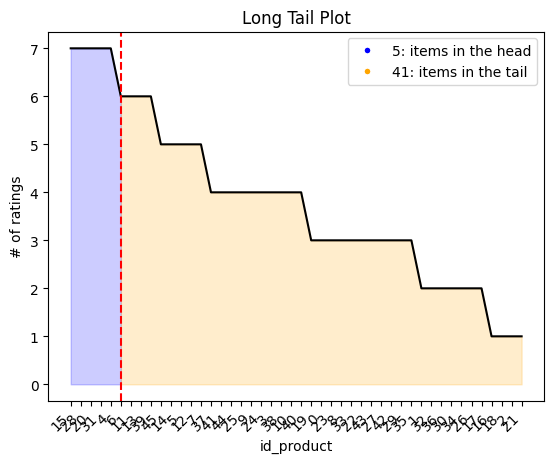

In [35]:
recmetrics.long_tail_plot(dfp_ratings, "id_product", "ratings", percentage=0.2)

#### recmetrics-pyspark

The recmetrics-pyspark implementation just adapts the one from recmetrics to accept pySpark dataframes, considering that there can be a huge amount of data, especially on the sales dataset

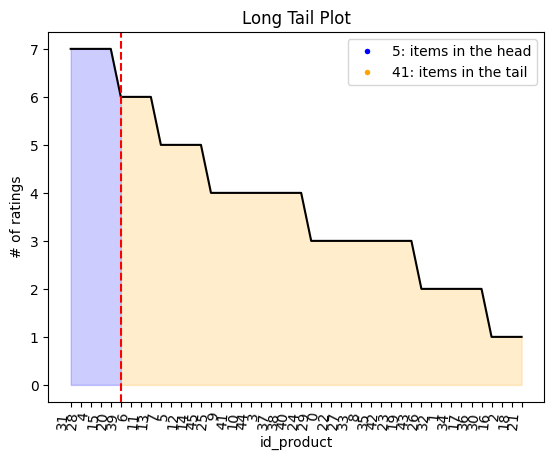

In [36]:
recmetrics_pyspark.long_tail_plot(df_ratings, "id_product", "ratings", percentage=0.2, xticks_rotation=85)

Note: there might be some local differences in the horizontal ordering as products share the same number of ratings or sales

### Coverage

This is a pretty simple one. It's just the ratio between distinct recommended products and those present in the original dataset, i.e.:

In [37]:
dfp_recommendations["id_product"].nunique() / dfp_ratings["id_product"].nunique()

0.8043478260869565

likewise,

In [38]:
len(set(df_recommendations.select("id_product").rdd.flatMap(lambda x: x).collect())) / \
len(set(df_ratings.select("id_product").rdd.flatMap(lambda x: x).collect()))

0.8043478260869565

#### recmetrics-pyspark

Essentially the cell above with pySpark DataFrames

In [39]:
recmetrics_pyspark.coverage(df_recommendations, df_ratings)

0.8043478260869565

### Novelty

For this metric we use a smaller dataset, starting from the format used by recmetrics

#### recmetrics

We start by creating example variables for recmetrics

In [40]:
ex_preds = [
    ['a', 'b', 'c'],
    ['d', 'e', 'f'],
    ['a', 'b', 'f'],
    ['d', 'e', 'c'],
]
pops = {
    'a': 8,
    'b': 3,
    'c': 1,
    'd': 4,
    'e': 7,
    'f': 6,
    'g': 7,
}
u = 10

In [41]:
recmetrics.novelty(ex_preds, pops, u, 3)

(1.325714774304043,
 [1.7936072613136436,
  0.8578222872944422,
  0.9319530944065916,
  1.7194764542014944])

In [42]:
recmetrics.novelty(ex_preds, pops, 6, 3)

(0.5887491801378368,
 [1.0566416671474375,
  0.1208566931282361,
  0.19498750024038544,
  0.9825108600352882])

#### recmetrics-pyspark

Refactoring recmetrics

In [43]:
recmetrics_pyspark.novelty_refac(ex_preds, pops, u, 3)

(1.325714774304043,
 [1.7936072613136436,
  0.8578222872944422,
  0.9319530944065916,
  1.7194764542014944])

In [44]:
recmetrics_pyspark.novelty_refac(ex_preds, pops, 6, 3)

(0.5887491801378368,
 [1.0566416671474375,
  0.1208566931282361,
  0.19498750024038544,
  0.9825108600352882])

pandas implementation

Now we create mock pandas DataFrames from the above variables, i.e., we create some "raw data"

In [45]:
# Recommendations DataFrame
dfp_ex_recommendations = pd.DataFrame(ex_preds)
dfp_ex_recommendations = dfp_ex_recommendations\
    .stack()\
    .droplevel(1)\
    .reset_index()\
    .rename(columns = {"index": "person", 0: "product"})
# just for consistency
dfp_ex_recommendations["rating"] = np.random.random(len(dfp_ex_recommendations)) * 5

# Sales DataFrame
l = []
for k, v in pops.items():
    l += list(zip(list(range(v)), [k] * v))
dfp_ex_sales = pd.DataFrame(l, columns=["person", "product"])

In [46]:
recmetrics_pyspark.novelty_pandas(dfp_ex_sales, dfp_ex_recommendations, u=10)

(1.325714774304043,
 [1.7936072613136436,
  0.8578222872944422,
  0.9319530944065916,
  1.7194764542014944])

In [47]:
recmetrics_pyspark.novelty_pandas(dfp_ex_sales, dfp_ex_recommendations, 8)

(1.0037866794166805,
 [1.4716791664262814,
  0.5358941924070799,
  0.6100249995192293,
  1.397548359314132])

Note: The default

#### pySpark implementation

In [48]:
# pySpark DataFrames from pandas DataFrames
df_ex_sales = spark.createDataFrame(dfp_ex_sales)
df_ex_recommendations = spark.createDataFrame(dfp_ex_recommendations)

In [49]:
recmetrics_pyspark.novelty(df_ex_sales, df_ex_recommendations, u=10)

(1.325714774304043,
 [1.7936072613136436,
  0.8578222872944422,
  0.9319530944065916,
  1.7194764542014942])

In [50]:
recmetrics_pyspark.novelty(df_ex_sales, df_ex_recommendations)

(1.0037866794166805,
 [1.4716791664262814,
  0.5358941924070799,
  0.6100249995192292,
  1.397548359314132])

### Personalization

We want it to be closer to one

#### recmetrics

In [51]:
rec_products_list = list(
    dfp_recommendations.groupby("person")["product"].agg(lambda x: list(x))
)

In [52]:
recmetrics.personalization(rec_products_list)

0.6933333333333334

#### recmetrics-pyspark

In [53]:
recmetrics_pyspark.personalization(df_recommendations, "person", "product")

0.6933333333333331

### Intra-list Similarity

Note: Even though the recmetrics-pyspark implementation (v0) uses pandas, it's not as costly as requiring a one-hot encoding DataFrame

#### recmetrics

In [54]:
dfp_prods_cat = dfp_products[["category", "id_product"]]
dfp_prods_cat = pd.get_dummies(dfp_prods_cat, columns=["category"]).set_index("id_product")

`dfp_prods_cat` might be expensive for big datasets

In [55]:
recmetrics.intra_list_similarity(rec_products_list, dfp_prods_cat)

0.4562962962962963

#### recmetrics-pyspark

In [56]:
df_ils = recmetrics_pyspark.intra_list_similarities(
    df=dfp_recommendations,
    col_group="person",
    col_index="product",
    col_columns="category",
    col_values="rating"
)
df_ils["intra_list_similarity"].mean()

0.45629629629629637